<a href="https://colab.research.google.com/github/Vo-Linh/Project_AI/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask and social distancing detection 😷 🌏

## DownLoading data

Data from kaggle: https://www.kaggle.com/andrewmvd/face-mask-detection

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"linhvo67","key":"f3aff670b32c9fda225f1366896a88a9"}'}

In [18]:
# Dowload data from kaggle
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!ls ~/.kaggle 
!chmod 600 /root/.kaggle/kaggle.json 
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

kaggle.json
100% 330M/330M [00:02<00:00, 132MB/s]



In [71]:
!kaggle datasets download -d lalitharajesh/haarcascades
!unzip /content/haarcascades.zip

  0% 0.00/1.45M [00:00<?, ?B/s]
100% 1.45M/1.45M [00:00<00:00, 39.9MB/s]
Archive:  /content/haarcascades.zip
  inflating: haarcascade_eye.xml     
  inflating: haarcascade_eye_tree_eyeglasses.xml  
  inflating: haarcascade_frontalcatface.xml  
  inflating: haarcascade_frontalcatface_extended.xml  
  inflating: haarcascade_frontalface_alt.xml  
  inflating: haarcascade_frontalface_alt2.xml  
  inflating: haarcascade_frontalface_alt_tree.xml  
  inflating: haarcascade_frontalface_default.xml  
  inflating: haarcascade_fullbody.xml  
  inflating: haarcascade_lefteye_2splits.xml  
  inflating: haarcascade_licence_plate_rus_16stages.xml  
  inflating: haarcascade_lowerbody.xml  
  inflating: haarcascade_profileface.xml  
  inflating: haarcascade_righteye_2splits.xml  
  inflating: haarcascade_russian_plate_number.xml  
  inflating: haarcascade_smile.xml   
  inflating: haarcascade_upperbody.xml  


In [19]:
!unzip /content/face-mask-12k-images-dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/Withou

In [12]:
import pandas as pd
import cv2
import numpy as np
from scipy.spatial import distance
import tensorflow as tf

In [20]:
# walk through file data
import os 
for dirname, _, filenames in os.walk('/content/Face Mask Dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
/content/Face Mask Dataset/Train/WithoutMask/256.png
/content/Face Mask Dataset/Train/WithoutMask/2613.png
/content/Face Mask Dataset/Train/WithoutMask/2351.png
/content/Face Mask Dataset/Train/WithoutMask/4875.png
/content/Face Mask Dataset/Train/WithoutMask/5589.png
/content/Face Mask Dataset/Train/WithoutMask/3310.png
/content/Face Mask Dataset/Train/WithoutMask/2224.png
/content/Face Mask Dataset/Train/WithoutMask/4661.png
/content/Face Mask Dataset/Train/WithoutMask/5914.png
/content/Face Mask Dataset/Train/WithoutMask/128.png
/content/Face Mask Dataset/Train/WithoutMask/5034.png
/content/Face Mask Dataset/Train/WithoutMask/2169.png
/content/Face Mask Dataset/Train/WithoutMask/5962.png
/content/Face Mask Dataset/Train/WithoutMask/1916.png
/content/Face Mask Dataset/Train/WithoutMask/2164.png
/content/Face Mask Dataset/Train/WithoutMask/4883.png
/content/Face Mask Dataset/Train/WithoutMask/3336.png
/content/Face Mask Dataset/

## Visualize data

We'll be using a Haar Cascade Model trained to detect faces in order to obtain the bounding box coordinates of faces in an image.

In [76]:
# loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

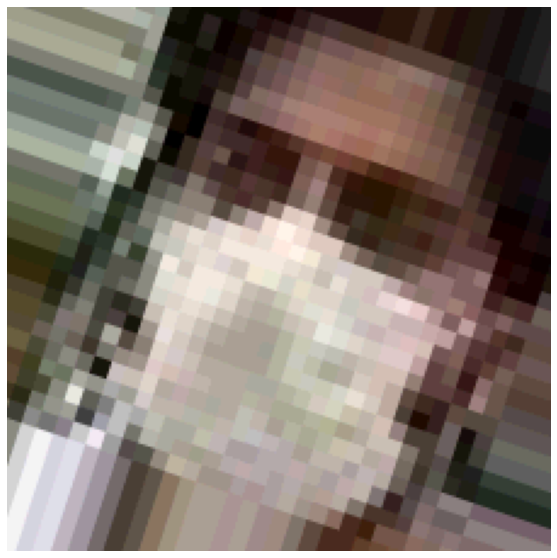

In [77]:
import matplotlib.pyplot as plt
import random

# trying out on sample image
path = '/content/Face Mask Dataset/Train/WithMask/' +  random.choice(os.listdir('/content/Face Mask Dataset/Train/WithMask'))
img = cv2.imread(path)

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE) # convert img into 2 dimensional

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img, (x,y), (x+w, y+h),(0,0,255),1)

plt.figure(figsize=(10, 10))
plt.imshow(out_img);
plt.axis(False);

### Detecting social distancing violations

In [29]:
MIN_DISTANCE = 130

In [30]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

No. of faces detected is less than 2


## Split data into train, validation and test set
![picture](![image.png](https://i.stack.imgur.com/RUkOB.png))

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir  = '/content/Face Mask Dataset/Train'
val_dir = '/content/Face Mask Dataset/Validation'
test_dir = '/content/Face Mask Dataset/Test'

# Data augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                  horizontal_flip=True, 
                                  rotation_range= 20, 
                                  shear_range=0.2,
                                  dtype = tf.float32)
train_generator = datagen.flow_from_directory(directory = train_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 32,
                                        class_mode = 'categorical')

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_datagen.flow_from_directory(val_dir,
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1.0/255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                             class_mode = 'categorical')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


## Create and train model
Using VGG19 for mask detection

In [34]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

In [39]:
vgg19 = VGG19(include_top= False, weights= 'imagenet', input_shape=(224, 224, 3))

for layer in vgg19.layers:
  layer.trainable = False

model = tf.keras.Sequential([
    vgg19,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
_________________________________________________________________


In [42]:
# Compile model
model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [45]:
# Fit model 
history = model.fit(train_generator,
                  steps_per_epoch = len(train_generator)//32,
                  epochs = 10,
                  validation_data = val_generator,
                  validation_steps = len(val_generator)//32)

Epoch 1/10
9/9 [==============================] - 190s 21s/step - loss: 1.2101 - accuracy: 0.5833
Epoch 2/10
9/9 [==============================] - 189s 21s/step - loss: 0.3467 - accuracy: 0.8403
Epoch 3/10
9/9 [==============================] - 189s 21s/step - loss: 0.1766 - accuracy: 0.9375
Epoch 4/10
9/9 [==============================] - 189s 21s/step - loss: 0.1578 - accuracy: 0.9410
Epoch 5/10
9/9 [==============================] - 189s 21s/step - loss: 0.0710 - accuracy: 0.9757
Epoch 6/10
9/9 [==============================] - 188s 21s/step - loss: 0.0677 - accuracy: 0.9757
Epoch 7/10
9/9 [==============================] - 188s 21s/step - loss: 0.0604 - accuracy: 0.9792
Epoch 8/10
9/9 [==============================] - 189s 21s/step - loss: 0.0485 - accuracy: 0.9896
Epoch 9/10
9/9 [==============================] - 191s 21s/step - loss: 0.0937 - accuracy: 0.9583
Epoch 10/10
9/9 [==============================] - 185s 21s/step - loss: 0.0836 - accuracy: 0.9688


In [50]:
model.evaluate(test_generator)

31/31 [==============================] - 642s 21s/step - loss: 0.0530 - accuracy: 0.9829


[0.052979808300733566, 0.9828628897666931]

## Save and use model

In [51]:
model.save('masknet.h5')

In [52]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

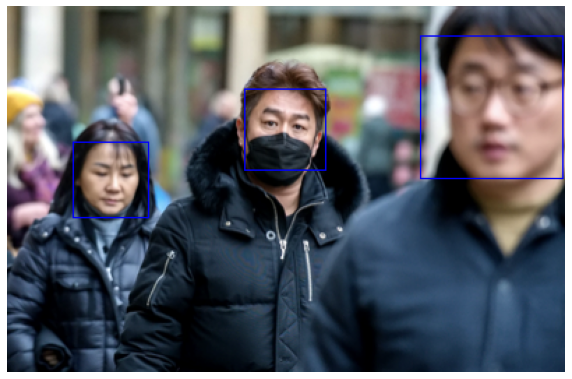

In [81]:
path = '/content/images/maksssksksss244.png'
img = cv2.imread(path)

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE) # convert img into 2 dimensional

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img, (x,y), (x+w, y+h),(0,0,255),1)

plt.figure(figsize=(10, 10))
plt.imshow(out_img);
plt.axis(False);

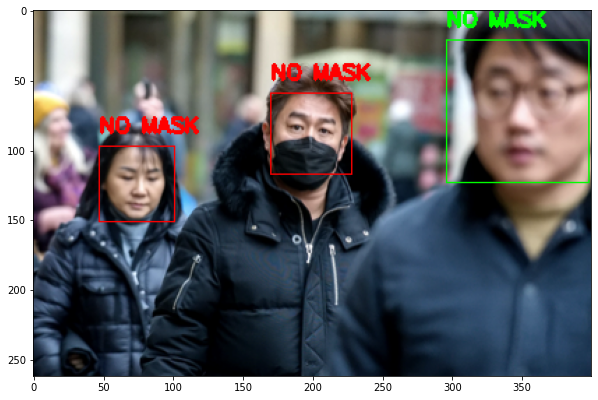

In [82]:
if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(224,224))
        crop = np.reshape(crop,[1,224,224,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")